In [23]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


In [24]:
# Генерація даних про користувачів стрімінгового сервісу
np.random.seed(42)
n_users = 500

data = {
    'WatchTime': np.random.randint(1, 50, n_users),  # Години на тиждень
    'ContentDiversity': np.random.randint(1, 100, n_users),  # Різноманітність контенту (1-100)
    'SessionFrequency': np.random.randint(1, 30, n_users)  # Сесій на місяць
}

df = pd.DataFrame(data)
print("Перші 5 користувачів:")
print(df.head())
print("\nСтатистика:")
print(df.describe())


Перші 5 користувачів:
   WatchTime  ContentDiversity  SessionFrequency
0         39                23                23
1         29                10                 9
2         15                69                23
3         43                34                 3
4          8                52                19

Статистика:
        WatchTime  ContentDiversity  SessionFrequency
count  500.000000        500.000000         500.00000
mean    25.678000         49.370000          14.48000
std     14.127898         29.195854           8.50307
min      1.000000          1.000000           1.00000
25%     14.000000         24.000000           7.00000
50%     26.000000         50.000000          14.00000
75%     37.000000         75.000000          22.00000
max     49.000000         99.000000          29.00000


In [25]:
# Стандартизація даних
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)


In [26]:
# Пошук оптимальної кількості кластерів
K_range = range(2, 11)
silhouette_scores = []

print("\nSilhouette Score для різних K:")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette={score:.3f}")

# Оптимальний K
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nОптимальна кількість кластерів: {optimal_k}")



Silhouette Score для різних K:
K=2: Silhouette=0.253
K=3: Silhouette=0.261
K=4: Silhouette=0.268
K=5: Silhouette=0.275
K=6: Silhouette=0.293
K=7: Silhouette=0.305
K=8: Silhouette=0.299
K=9: Silhouette=0.287
K=10: Silhouette=0.284

Оптимальна кількість кластерів: 7


In [27]:
# Кластеризація з оптимальним K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)


In [28]:
# Аналіз кластерів
print("\nАналіз кластерів:")
cluster_summary = df.groupby('Cluster').agg({
    'WatchTime': ['mean', 'std'],
    'ContentDiversity': ['mean', 'std'],
    'SessionFrequency': ['mean', 'std']
}).round(2)
print(cluster_summary)

print("\nРозмір кластерів:")
print(df['Cluster'].value_counts().sort_index())



Аналіз кластерів:
        WatchTime       ContentDiversity        SessionFrequency      
             mean   std             mean    std             mean   std
Cluster                                                               
0           11.63  6.94            43.83  20.40            22.39  3.54
1           37.57  7.34            22.58  13.54             8.05  4.47
2            9.38  6.16            85.44   9.68            10.91  5.91
3           11.75  7.27            29.82  16.38             6.16  3.85
4           33.57  8.12            73.43  13.82             7.93  4.39
5           34.00  8.46            76.06  14.89            23.37  3.74
6           35.99  8.21            20.96  13.72            22.21  4.23

Розмір кластерів:
Cluster
0    70
1    77
2    55
3    73
4    76
5    78
6    71
Name: count, dtype: int64


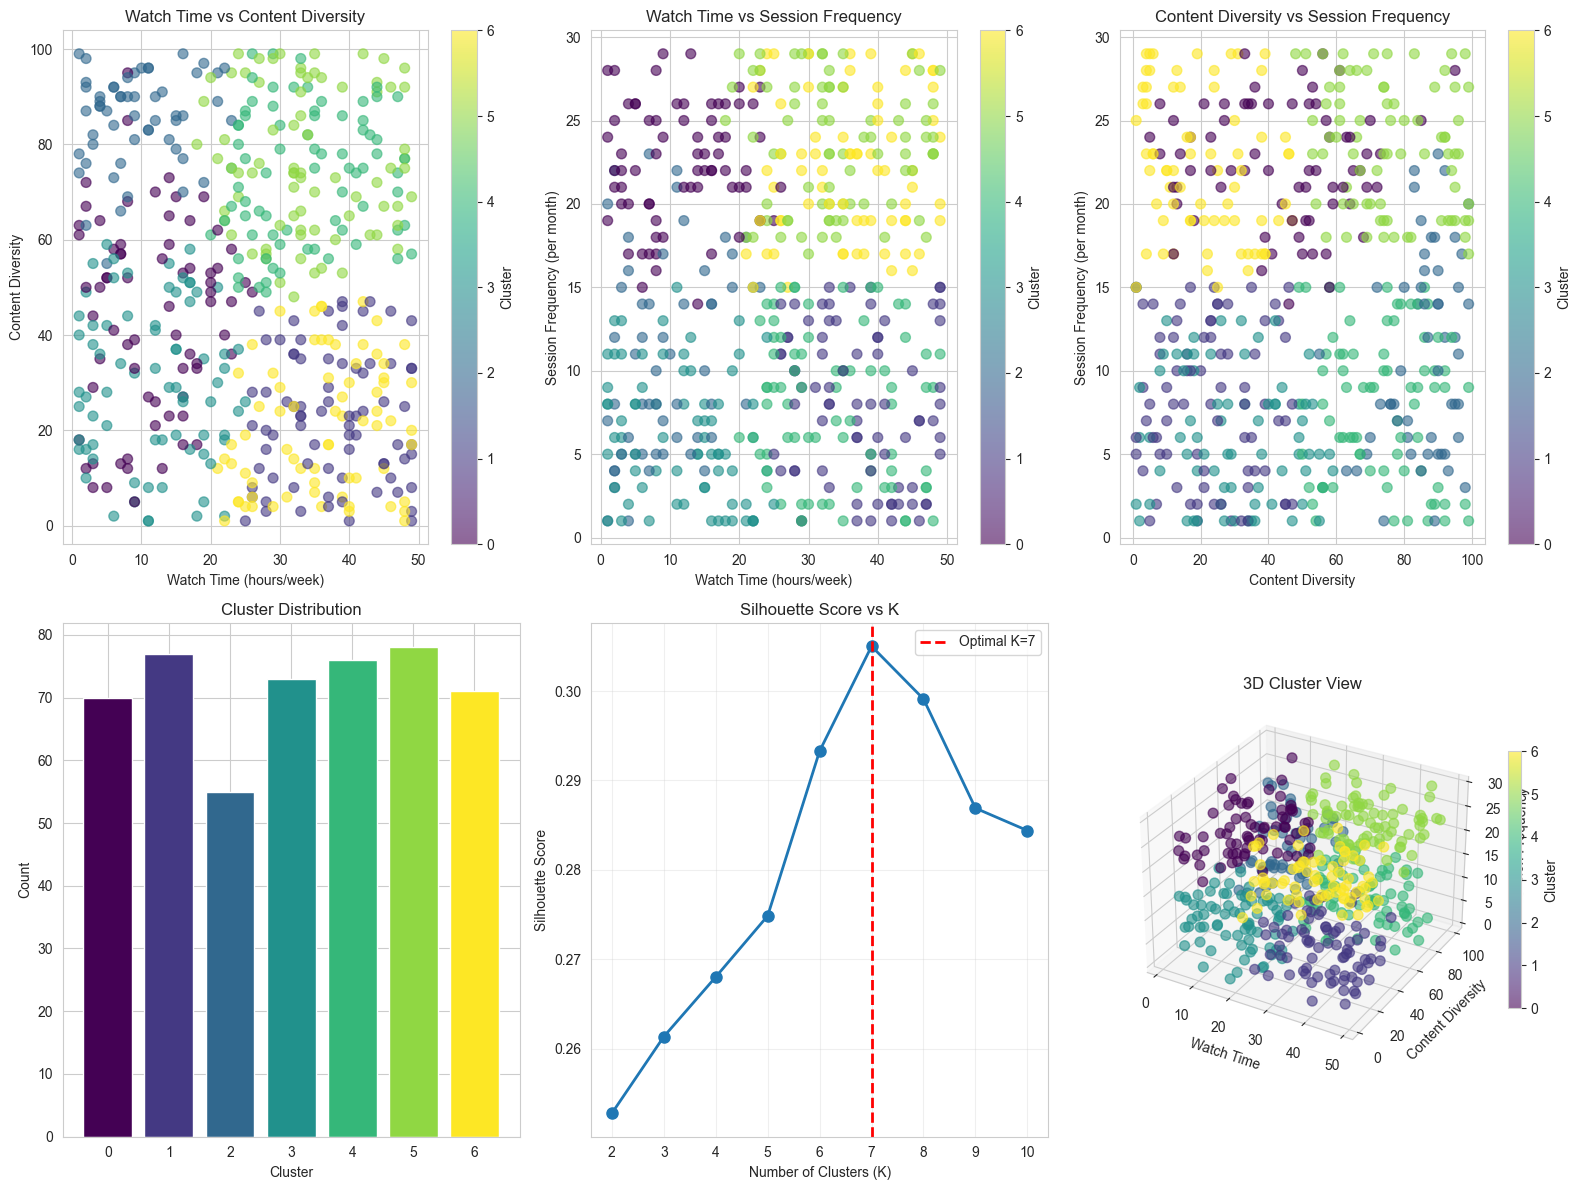

In [29]:
# Візуалізація
fig = plt.figure(figsize=(16, 12))

# 1. WatchTime vs ContentDiversity
ax1 = plt.subplot(2, 3, 1)
scatter1 = ax1.scatter(df['WatchTime'], df['ContentDiversity'],
                       c=df['Cluster'], cmap='viridis', alpha=0.6, s=50)
ax1.set_xlabel('Watch Time (hours/week)')
ax1.set_ylabel('Content Diversity')
ax1.set_title('Watch Time vs Content Diversity')
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# 2. WatchTime vs SessionFrequency
ax2 = plt.subplot(2, 3, 2)
scatter2 = ax2.scatter(df['WatchTime'], df['SessionFrequency'],
                       c=df['Cluster'], cmap='viridis', alpha=0.6, s=50)
ax2.set_xlabel('Watch Time (hours/week)')
ax2.set_ylabel('Session Frequency (per month)')
ax2.set_title('Watch Time vs Session Frequency')
plt.colorbar(scatter2, ax=ax2, label='Cluster')

# 3. ContentDiversity vs SessionFrequency
ax3 = plt.subplot(2, 3, 3)
scatter3 = ax3.scatter(df['ContentDiversity'], df['SessionFrequency'],
                       c=df['Cluster'], cmap='viridis', alpha=0.6, s=50)
ax3.set_xlabel('Content Diversity')
ax3.set_ylabel('Session Frequency (per month)')
ax3.set_title('Content Diversity vs Session Frequency')
plt.colorbar(scatter3, ax=ax3, label='Cluster')

# 4. Розподіл кластерів
ax4 = plt.subplot(2, 3, 4)
cluster_counts = df['Cluster'].value_counts().sort_index()
bars = ax4.bar(cluster_counts.index, cluster_counts.values,
               color=plt.cm.viridis(np.linspace(0, 1, len(cluster_counts))))
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Count')
ax4.set_title('Cluster Distribution')
ax4.set_xticks(cluster_counts.index)

# 5. Silhouette Score по K
ax5 = plt.subplot(2, 3, 5)
ax5.plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8)
ax5.axvline(optimal_k, color='red', linestyle='--', linewidth=2, label=f'Optimal K={optimal_k}')
ax5.set_xlabel('Number of Clusters (K)')
ax5.set_ylabel('Silhouette Score')
ax5.set_title('Silhouette Score vs K')
ax5.grid(True, alpha=0.3)
ax5.legend()

# 6. 3D візуалізація
ax6 = plt.subplot(2, 3, 6, projection='3d')
scatter_3d = ax6.scatter(df['WatchTime'], df['ContentDiversity'], df['SessionFrequency'],
                         c=df['Cluster'], cmap='viridis', alpha=0.6, s=50)
ax6.set_xlabel('Watch Time')
ax6.set_ylabel('Content Diversity')
ax6.set_zlabel('Session Frequency')
ax6.set_title('3D Cluster View')
plt.colorbar(scatter_3d, ax=ax6, label='Cluster', shrink=0.5)

plt.tight_layout()
plt.show()


In [30]:
# Інтерпретація кластерів
print("\nІнтерпретація кластерів:")

for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    avg_watch = cluster_data['WatchTime'].mean()
    avg_diversity = cluster_data['ContentDiversity'].mean()
    avg_frequency = cluster_data['SessionFrequency'].mean()

    # Визначення типу користувача
    if avg_watch > 30 and avg_frequency > 20:
        cluster_type = "Hardcore Fans"
    elif avg_watch > 30:
        cluster_type = "Binge Watchers"
    elif avg_frequency > 20:
        cluster_type = "Frequent Users"
    elif avg_diversity > 70:
        cluster_type = "Content Explorers"
    elif avg_watch < 15 and avg_frequency < 10:
        cluster_type = "Casual Viewers"
    else:
        cluster_type = "Regular Users"

    print(f"\nCluster {cluster}: {cluster_type}")
    print(f"  Users: {len(cluster_data)}")
    print(f"  Watch Time: {avg_watch:.1f} hours/week")
    print(f"  Content Diversity: {avg_diversity:.1f}/100")
    print(f"  Session Frequency: {avg_frequency:.1f} times/month")


Інтерпретація кластерів:

Cluster 0: Frequent Users
  Users: 70
  Watch Time: 11.6 hours/week
  Content Diversity: 43.8/100
  Session Frequency: 22.4 times/month

Cluster 1: Binge Watchers
  Users: 77
  Watch Time: 37.6 hours/week
  Content Diversity: 22.6/100
  Session Frequency: 8.1 times/month

Cluster 2: Content Explorers
  Users: 55
  Watch Time: 9.4 hours/week
  Content Diversity: 85.4/100
  Session Frequency: 10.9 times/month

Cluster 3: Casual Viewers
  Users: 73
  Watch Time: 11.8 hours/week
  Content Diversity: 29.8/100
  Session Frequency: 6.2 times/month

Cluster 4: Binge Watchers
  Users: 76
  Watch Time: 33.6 hours/week
  Content Diversity: 73.4/100
  Session Frequency: 7.9 times/month

Cluster 5: Hardcore Fans
  Users: 78
  Watch Time: 34.0 hours/week
  Content Diversity: 76.1/100
  Session Frequency: 23.4 times/month

Cluster 6: Hardcore Fans
  Users: 71
  Watch Time: 36.0 hours/week
  Content Diversity: 21.0/100
  Session Frequency: 22.2 times/month
